## Gradient boosting

**Gradient boosting** combina modelos débiles para crear un modelo fuerte mediante la corrección iterativa de los errores de los modelos anteriores.

En este notebook utilizaremos LightGBM desarrollado por Microsoft, una biblioteca que implementa gradient boosting especialmente optimizado.

## Learning to Rank

**Learning to rank (LTR)** es un subcampo de ML aplicable a una variedad de problemas del mundo real relacionados con la predicción de rankings o la recomendación de candidatos.

Utilizaremos un dataset de series de anime para implementar un rankeo.

A diferencia de los datos de los search engines, en este caso no tenemos pares `(query, documents) `.

Trataremos a los usuarios como consultas y a los animes en los que están interesados como documentos:` (usuario, animes)`.

### Librerías

In [ ]:
!pip3 install shap
!pip3 install lightgbm

In [ ]:
import pandas as pd
import numpy as np
import shap
import zipfile
import matplotlib.pyplot as plt
import warnings
from sklearn import preprocessing,model_selection,metrics
from sklearn.preprocessing import MultiLabelBinarizer
from lightgbm import LGBMRanker
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score,coverage_error

### Construcción de datasets y análisis exploratorio

Utilizaremos el siguiente dataset: https://www.kaggle.com/datasets/ransakaravihara/anime-recommendation-ltr-dataset

In [3]:
!kaggle datasets download -d ransakaravihara/anime-recommendation-ltr-dataset

Dataset URL: https://www.kaggle.com/datasets/ransakaravihara/anime-recommendation-ltr-dataset
License(s): CC0-1.0
anime-recommendation-ltr-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
zipped_data = zipfile.ZipFile("anime-recommendation-ltr-dataset.zip")

In [5]:
zipped_data.namelist()

['anime_info.csv', 'relavence_scores.csv', 'user_info.csv']

In [6]:
anime_info_df = pd.read_csv(zipped_data.open('anime_info.csv'))
relavence_scores = pd.read_csv(zipped_data.open('relavence_scores.csv'))
user_info = pd.read_csv(zipped_data.open('user_info.csv'))

In [7]:
relavence_scores = relavence_scores[~(relavence_scores['user_id']==11100)]

In [8]:
# Cada usuario asigna una relevancia de 0 a 1 a cada anime
relavence_scores.head()

,anime_id,Name,user_id,relavence_score
0,1,Cowboy Bebop,3,1.000000
1,1,Cowboy Bebop,6,1.000000
2,1,Cowboy Bebop,8,0.230769
3,1,Cowboy Bebop,13,0.000000
4,1,Cowboy Bebop,14,0.500000


In [9]:
relavence_scores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4864759 entries, 0 to 4878998
Data columns (total 4 columns):
 #   Column           Dtype  
---  ------           -----  
 0   anime_id         int64  
 1   Name             object 
 2   user_id          int64  
 3   relavence_score  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 185.6+ MB


In [10]:
# Dataset con los usuarios
user_info.head()

,user_id,review_count,avg_score,score_stddev,above_five_star_count,above_five_star_ratio
0,3,357,6.801120,2.475089,318.0,0.890756
1,6,545,4.089908,3.731472,285.0,0.522936
2,8,165,0.866667,2.448328,NaN,NaN
3,13,65,3.338462,4.191796,NaN,NaN
4,14,146,4.965753,3.844233,89.0,0.609589


In [11]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15163 entries, 0 to 15162
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                15163 non-null  int64  
 1   review_count           15163 non-null  int64  
 2   avg_score              15163 non-null  float64
 3   score_stddev           15023 non-null  float64
 4   above_five_star_count  8631 non-null   float64
 5   above_five_star_ratio  8631 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 710.9 KB


In [12]:
# Dataset con los animes
anime_info_df.head()

,anime_id,Genres,is_tv,year_aired,is_adult,above_five_star_users,above_five_star_ratings,above_five_star_ratio
0,1,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",1,1998.0,1,4012.0,4012.0,0.594018
1,5,"Action, Drama, Mystery, Sci-Fi, Space",0,2001.0,1,NaN,NaN,NaN
2,6,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",1,1998.0,0,NaN,NaN,NaN
3,7,"Action, Mystery, Police, Supernatural, Drama, ...",1,2002.0,0,NaN,NaN,NaN
4,8,"Adventure, Fantasy, Shounen, Supernatural",1,2004.0,0,76.0,76.0,0.481013


In [13]:
anime_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16681 entries, 0 to 16680
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   anime_id                 16681 non-null  int64  
 1   Genres                   16627 non-null  object 
 2   is_tv                    16681 non-null  int64  
 3   year_aired               16558 non-null  float64
 4   is_adult                 16681 non-null  int64  
 5   above_five_star_users    5669 non-null   float64
 6   above_five_star_ratings  5669 non-null   float64
 7   above_five_star_ratio    5669 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


In [14]:
# Extrae todos los géneros
genres = anime_info_df['Genres'].str.split(', ')

genre_counts = genres.explode().value_counts()

sorted_genres = genre_counts.sort_values(ascending=False)

# Top k géneros
k = 10
top_k_genres = sorted_genres.head(k)

print(top_k_genres)

Genres
Comedy       5811
Action       3755
Fantasy      3095
Adventure    2864
Sci-Fi       2518
Drama        2473
Kids         2335
Music        2182
Shounen      1954
Romance      1843
Name: count, dtype: int64


In [15]:
popular_genres = top_k_genres.index.tolist()
print(popular_genres)

['Comedy', 'Action', 'Fantasy', 'Adventure', 'Sci-Fi', 'Drama', 'Kids', 'Music', 'Shounen', 'Romance']


In [16]:
def create_genre_flags(df, popular_genres):
    df = df.dropna(subset=['Genres'])
    df['Genres'] = df['Genres'].apply(lambda x:",".join(s.strip() for s in x.split(",")))
    # Use MultiLabelBinarizer to create a one-hot encoded dataframe of the genres
    mlb = MultiLabelBinarizer()
    genre_df = pd.DataFrame(mlb.fit_transform(df['Genres'].str.split(',')),
                            columns=mlb.classes_,
                            index=df.index)
    # Create a new dataframe with the movie id and genre columns
    new_df = pd.concat([df['anime_id'], genre_df[popular_genres]], axis=1)
    new_df.columns = ['anime_id'] + popular_genres
    return new_df

In [17]:
anime_genre_info_df = create_genre_flags(anime_info_df,popular_genres)

<ipython-input-16-a1a60ea641bf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Genres'] = df['Genres'].apply(lambda x:",".join(s.strip() for s in x.split(",")))


In [18]:
anime_genre_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16627 entries, 0 to 16680
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   anime_id   16627 non-null  int64
 1   Comedy     16627 non-null  int64
 2   Action     16627 non-null  int64
 3   Fantasy    16627 non-null  int64
 4   Adventure  16627 non-null  int64
 5   Sci-Fi     16627 non-null  int64
 6   Drama      16627 non-null  int64
 7   Kids       16627 non-null  int64
 8   Music      16627 non-null  int64
 9   Shounen    16627 non-null  int64
 10  Romance    16627 non-null  int64
dtypes: int64(11)
memory usage: 1.5 MB


In [19]:
anime_genre_info_df.head()

,anime_id,Comedy,Action,Fantasy,Adventure,Sci-Fi,Drama,Kids,Music,Shounen,Romance
0,1,1,1,0,1,1,1,0,0,0,0
1,5,0,1,0,0,1,1,0,0,0,0
2,6,1,1,0,1,1,1,0,0,1,0
3,7,0,1,0,0,0,1,0,0,0,0
4,8,0,0,1,1,0,0,0,0,1,0


In [20]:
anime_info_df_final = anime_info_df.merge(anime_genre_info_df,on='anime_id')

In [21]:
anime_info_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16627 entries, 0 to 16626
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   anime_id                 16627 non-null  int64  
 1   Genres                   16627 non-null  object 
 2   is_tv                    16627 non-null  int64  
 3   year_aired               16505 non-null  float64
 4   is_adult                 16627 non-null  int64  
 5   above_five_star_users    5655 non-null   float64
 6   above_five_star_ratings  5655 non-null   float64
 7   above_five_star_ratio    5655 non-null   float64
 8   Comedy                   16627 non-null  int64  
 9   Action                   16627 non-null  int64  
 10  Fantasy                  16627 non-null  int64  
 11  Adventure                16627 non-null  int64  
 12  Sci-Fi                   16627 non-null  int64  
 13  Drama                    16627 non-null  int64  
 14  Kids                  

In [22]:
anime_info_df_final.head()

,anime_id,Genres,is_tv,year_aired,is_adult,above_five_star_users,above_five_star_ratings,above_five_star_ratio,Comedy,Action,Fantasy,Adventure,Sci-Fi,Drama,Kids,Music,Shounen,Romance
0,1,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",1,1998.0,1,4012.0,4012.0,0.594018,1,1,0,1,1,1,0,0,0,0
1,5,"Action, Drama, Mystery, Sci-Fi, Space",0,2001.0,1,NaN,NaN,NaN,0,1,0,0,1,1,0,0,0,0
2,6,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",1,1998.0,0,NaN,NaN,NaN,1,1,0,1,1,1,0,0,1,0
3,7,"Action, Mystery, Police, Supernatural, Drama, ...",1,2002.0,0,NaN,NaN,NaN,0,1,0,0,0,1,0,0,0,0
4,8,"Adventure, Fantasy, Shounen, Supernatural",1,2004.0,0,76.0,76.0,0.481013,0,0,1,1,0,0,0,0,1,0


In [23]:
del anime_info_df_final['Genres']

In [24]:
anime_info_df_final.head()

,anime_id,is_tv,year_aired,is_adult,above_five_star_users,above_five_star_ratings,above_five_star_ratio,Comedy,Action,Fantasy,Adventure,Sci-Fi,Drama,Kids,Music,Shounen,Romance
0,1,1,1998.0,1,4012.0,4012.0,0.594018,1,1,0,1,1,1,0,0,0,0
1,5,0,2001.0,1,NaN,NaN,NaN,0,1,0,0,1,1,0,0,0,0
2,6,1,1998.0,0,NaN,NaN,NaN,1,1,0,1,1,1,0,0,1,0
3,7,1,2002.0,0,NaN,NaN,NaN,0,1,0,0,0,1,0,0,0,0
4,8,1,2004.0,0,76.0,76.0,0.481013,0,0,1,1,0,0,0,0,1,0


Transformamos los textos de las columnas

In [25]:
anime_info_df_final.columns = [col if col=='anime_id' else f"ANIME_FEATURE {col}".upper() for col in anime_info_df_final.columns]

In [26]:
user_info.columns = [col if col=='user_id' else f"USER_FEATURE {col}".upper() for col in user_info.columns]

Algunos histogramas

In [27]:
def create_histogram(data, xname, n_bins=100, background_color='#F3F3F3', title=None):

    import matplotlib as mpl
    mpl.rcParams['font.size'] = 15
    mpl.rcParams['font.family'] = 'sans-serif'
    # mpl.rcParams['font.weight'] = 'semibold'

    plt.figure(figsize=(5,5))
    plt.hist(data, bins=n_bins, color='#2596be', edgecolor='black')
    plt.xlabel(xname)
    plt.ylabel('Frequency')
    ax = plt.gca()
    ax.set_facecolor(background_color)
    plt.grid(True, which='both', color='lightgray', linewidth=0.5)
    plt.title(title.upper(),fontweight='semibold',fontfamily='sans-serif')
    plt.show()

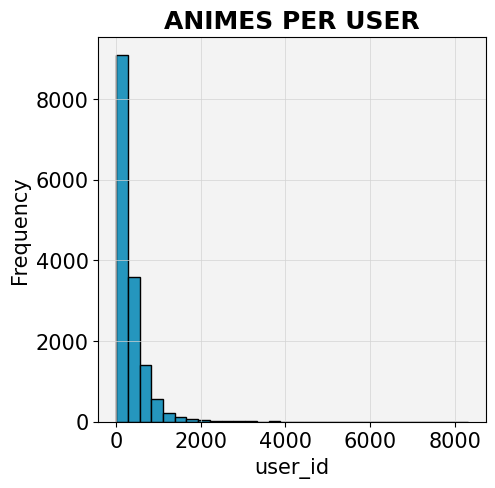

In [28]:
create_histogram(relavence_scores.groupby("user_id")['user_id'].agg('count'),xname='user_id', n_bins=30, title='Animes per user')

In [29]:
train_intermedio = relavence_scores.merge(anime_info_df_final)
train = train_intermedio.merge(user_info,how='inner')

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4864372 entries, 0 to 4864371
Data columns (total 25 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   anime_id                               int64  
 1   Name                                   object 
 2   user_id                                int64  
 3   relavence_score                        float64
 4   ANIME_FEATURE IS_TV                    int64  
 5   ANIME_FEATURE YEAR_AIRED               float64
 6   ANIME_FEATURE IS_ADULT                 int64  
 7   ANIME_FEATURE ABOVE_FIVE_STAR_USERS    float64
 8   ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS  float64
 9   ANIME_FEATURE ABOVE_FIVE_STAR_RATIO    float64
 10  ANIME_FEATURE COMEDY                   int64  
 11  ANIME_FEATURE ACTION                   int64  
 12  ANIME_FEATURE FANTASY                  int64  
 13  ANIME_FEATURE ADVENTURE                int64  
 14  ANIME_FEATURE SCI-FI                   int64  
 15

In [31]:
train.head()

,anime_id,Name,user_id,relavence_score,ANIME_FEATURE IS_TV,ANIME_FEATURE YEAR_AIRED,ANIME_FEATURE IS_ADULT,ANIME_FEATURE ABOVE_FIVE_STAR_USERS,ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS,ANIME_FEATURE ABOVE_FIVE_STAR_RATIO,...,ANIME_FEATURE DRAMA,ANIME_FEATURE KIDS,ANIME_FEATURE MUSIC,ANIME_FEATURE SHOUNEN,ANIME_FEATURE ROMANCE,USER_FEATURE REVIEW_COUNT,USER_FEATURE AVG_SCORE,USER_FEATURE SCORE_STDDEV,USER_FEATURE ABOVE_FIVE_STAR_COUNT,USER_FEATURE ABOVE_FIVE_STAR_RATIO
0,1,Cowboy Bebop,3,1.0,1,1998.0,1,4012.0,4012.0,0.594018,...,1,0,0,0,0,357,6.80112,2.475089,318.0,0.890756
1,18,Initial D Fourth Stage,3,1.0,1,2004.0,0,613.0,613.0,0.656317,...,1,0,0,0,0,357,6.80112,2.475089,318.0,0.890756
2,25,Sunabouzu,3,0.0,1,2004.0,1,NaN,NaN,NaN,...,0,0,0,1,0,357,6.80112,2.475089,318.0,0.890756
3,30,Neon Genesis Evangelion,3,1.0,1,1995.0,0,4478.0,4478.0,0.655541,...,1,0,0,0,0,357,6.80112,2.475089,318.0,0.890756
4,43,Koukaku Kidoutai,3,1.0,0,1995.0,0,2353.0,2353.0,0.629144,...,0,0,0,0,0,357,6.80112,2.475089,318.0,0.890756


In [32]:
na_counts = (train.isna().sum() * 100/len(train))
na_counts

anime_id                                  0.000000
Name                                      0.000000
user_id                                   0.000000
relavence_score                           0.000000
ANIME_FEATURE IS_TV                       0.000000
ANIME_FEATURE YEAR_AIRED                  0.082642
ANIME_FEATURE IS_ADULT                    0.000000
ANIME_FEATURE ABOVE_FIVE_STAR_USERS      47.565174
ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS    47.565174
ANIME_FEATURE ABOVE_FIVE_STAR_RATIO      47.565174
ANIME_FEATURE COMEDY                      0.000000
ANIME_FEATURE ACTION                      0.000000
ANIME_FEATURE FANTASY                     0.000000
ANIME_FEATURE ADVENTURE                   0.000000
ANIME_FEATURE SCI-FI                      0.000000
ANIME_FEATURE DRAMA                       0.000000
ANIME_FEATURE KIDS                        0.000000
ANIME_FEATURE MUSIC                       0.000000
ANIME_FEATURE SHOUNEN                     0.000000
ANIME_FEATURE ROMANCE          

In [33]:
train_processed = train.drop(na_counts[na_counts > 50].index,axis=1)

In [34]:
train_processed.sort_values(by='user_id',inplace=True)

In [35]:
train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4864372 entries, 3735597 to 4812613
Data columns (total 25 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   anime_id                               int64  
 1   Name                                   object 
 2   user_id                                int64  
 3   relavence_score                        float64
 4   ANIME_FEATURE IS_TV                    int64  
 5   ANIME_FEATURE YEAR_AIRED               float64
 6   ANIME_FEATURE IS_ADULT                 int64  
 7   ANIME_FEATURE ABOVE_FIVE_STAR_USERS    float64
 8   ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS  float64
 9   ANIME_FEATURE ABOVE_FIVE_STAR_RATIO    float64
 10  ANIME_FEATURE COMEDY                   int64  
 11  ANIME_FEATURE ACTION                   int64  
 12  ANIME_FEATURE FANTASY                  int64  
 13  ANIME_FEATURE ADVENTURE                int64  
 14  ANIME_FEATURE SCI-FI                   int64  
 1

In [36]:
train_processed.set_index("user_id",inplace=True)

In [37]:
train_processed.columns

Index(['anime_id', 'Name', 'relavence_score', 'ANIME_FEATURE IS_TV',
       'ANIME_FEATURE YEAR_AIRED', 'ANIME_FEATURE IS_ADULT',
       'ANIME_FEATURE ABOVE_FIVE_STAR_USERS',
       'ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS',
       'ANIME_FEATURE ABOVE_FIVE_STAR_RATIO', 'ANIME_FEATURE COMEDY',
       'ANIME_FEATURE ACTION', 'ANIME_FEATURE FANTASY',
       'ANIME_FEATURE ADVENTURE', 'ANIME_FEATURE SCI-FI',
       'ANIME_FEATURE DRAMA', 'ANIME_FEATURE KIDS', 'ANIME_FEATURE MUSIC',
       'ANIME_FEATURE SHOUNEN', 'ANIME_FEATURE ROMANCE',
       'USER_FEATURE REVIEW_COUNT', 'USER_FEATURE AVG_SCORE',
       'USER_FEATURE SCORE_STDDEV', 'USER_FEATURE ABOVE_FIVE_STAR_COUNT',
       'USER_FEATURE ABOVE_FIVE_STAR_RATIO'],
      dtype='object')

In [38]:
features = train_processed.columns[3:]
features

Index(['ANIME_FEATURE IS_TV', 'ANIME_FEATURE YEAR_AIRED',
       'ANIME_FEATURE IS_ADULT', 'ANIME_FEATURE ABOVE_FIVE_STAR_USERS',
       'ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS',
       'ANIME_FEATURE ABOVE_FIVE_STAR_RATIO', 'ANIME_FEATURE COMEDY',
       'ANIME_FEATURE ACTION', 'ANIME_FEATURE FANTASY',
       'ANIME_FEATURE ADVENTURE', 'ANIME_FEATURE SCI-FI',
       'ANIME_FEATURE DRAMA', 'ANIME_FEATURE KIDS', 'ANIME_FEATURE MUSIC',
       'ANIME_FEATURE SHOUNEN', 'ANIME_FEATURE ROMANCE',
       'USER_FEATURE REVIEW_COUNT', 'USER_FEATURE AVG_SCORE',
       'USER_FEATURE SCORE_STDDEV', 'USER_FEATURE ABOVE_FIVE_STAR_COUNT',
       'USER_FEATURE ABOVE_FIVE_STAR_RATIO'],
      dtype='object')

In [39]:
target = train_processed.columns[2]
target

'relavence_score'

Nuestro target a predecir aquí es relavance_score, almacenada en el conjunto de datos relevance_scores.

Nuestro modelo de LightGBM aprenderá una función para clasificar animes en un orden óptimo (del más relevante al menos relevante) para un dado usuario.

### Entrenamiento

In [40]:
test_size = int(1e5) # 100,000

X, y = train_processed[features], train_processed[target].apply(lambda x:int(x*10))
test_idx_start = len(X)-test_size

xtrain, xtest, ytrain, ytest = X.iloc[0:test_idx_start], X.iloc[test_idx_start:], y.iloc[0:test_idx_start], y.iloc[test_idx_start:]

In [41]:
get_group_size = lambda df: df.reset_index().groupby("user_id")['user_id'].count()

 La idea del parámetro de grupo es dividir el conjunto de datos para cada par `(consulta, documento)`. Esto permite que el modelo aprenda la importancia relativa de diferentes características dentro de cada grupo, lo que puede mejorar el rendimiento general del modelo.

Por ejemplo, para un dataset de 6 elementos con  grupo = [3, 2, 1]:

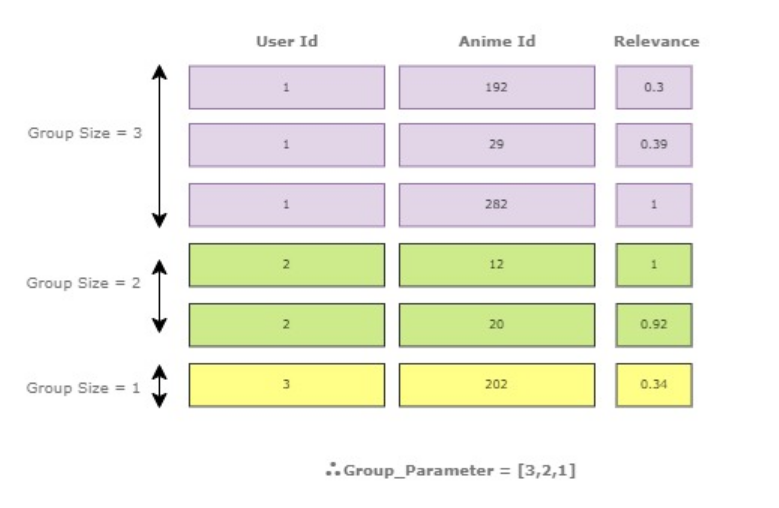

In [42]:
train_groups = get_group_size(xtrain)
test_groups = get_group_size(xtest)

In [43]:
train_groups

user_id
0          71
1         126
2         484
3         357
4         155
         ... 
16162      60
16163     313
16165      92
16166     705
16167    1516
Name: user_id, Length: 14841, dtype: int64

In [44]:
sum(train_groups) , sum(test_groups)

(4764372, 100000)

**Entrenamiento de LightGBM**

- Función objetivo: Lambda Rank

LambdaRank es una función objetivo diseñada para optimizar directamente métricas de clasificación basadas en rankings, como el NDCG (Normalized Discounted Cumulative Gain) o el MAP (Mean Average Precision), comunes en sistemas de recuperación de información y sistemas de recomendación.

LambdaRank se enfoca en optimizar la ordenación relativa de los resultados de búsqueda o recomendación, en lugar de simplemente predecir etiquetas binarias o de regresión.

- n_estimators

Especifica el número de iteraciones de boosting que el modelo utilizará. Más iteraciones pueden mejorar potencialmente el rendimiento del modelo, pero también aumentan el tiempo de entrenamiento y el riesgo de sobreajuste.

In [45]:
model = LGBMRanker(objective="lambdarank", n_estimators=20)
model.fit(xtrain,ytrain,group=train_groups,eval_set=[(xtest,ytest)],eval_group=[test_groups],eval_metric=['map'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total groups: 14841, total data: 4764372
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.087750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2118
[LightGBM] [Info] Number of data points in the train set: 4764372, number of used features: 21
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total groups: 322, total data: 100000


LGBMRanker(n_estimators=20, objective='lambdarank')

### Resultados

In [46]:
user_2_anime_df = relavence_scores.groupby("user_id").agg({"anime_id":lambda x:list(set(x))})

In [47]:
user_2_anime_df

,anime_id
user_id,
0,"[256, 3457, 134, 269, 272, 19, 1047, 24, 1689,..."
1,"[3588, 39940, 22535, 31240, 35847, 35849, 2817..."
2,"[12293, 22535, 36876, 22543, 14353, 19, 36885,..."
3,"[1, 12291, 28677, 22535, 30727, 14345, 18, 616..."
4,"[2563, 1029, 1542, 16, 530, 1043, 3091, 1562, ..."
...,...
16504,"[1, 5, 6, 22535, 28677, 14345, 14349, 19, 20, ..."
16505,"[4224, 24833, 9989, 6, 22535, 136, 35848, 3034..."
16506,"[43013, 36876, 22543, 18455, 36889, 10280, 143..."


In [48]:
user_2_anime_map = dict(zip(user_2_anime_df.index,user_2_anime_df['anime_id']))

In [49]:
# animes candidatos a ser rankeados
candidate_pool = anime_info_df_final['anime_id'].unique().tolist()

In [50]:
# animes candidatos a ser rankeados y no vistos por cierto usuario
def candidate_generation(user_id,candidate_pool,user_2_anime_map,N):
    already_interacted = user_2_anime_map[user_id]
    candidates = list(set(candidate_pool) - set(already_interacted))
    return already_interacted,np.random.choice(candidates,size=N)

In [51]:
anime_id_2_name = relavence_scores.drop_duplicates(subset=["anime_id","Name"])[['anime_id',"Name"]]
anime_id_2_name_map = dict(zip(anime_id_2_name['anime_id'],anime_id_2_name['Name']))
anime_id_2_name_map[1]

'Cowboy Bebop'

In [52]:
anime_id_2_name_map

{1: 'Cowboy Bebop',
 5: 'Cowboy Bebop: Tengoku no Tobira',
 6: 'Trigun',
 7: 'Witch Hunter Robin',
 8: 'Bouken Ou Beet',
 15: 'Eyeshield 21',
 16: 'Hachimitsu to Clover',
 17: 'Hungry Heart: Wild Striker',
 18: 'Initial D Fourth Stage',
 19: 'Monster',
 20: 'Naruto',
 22: 'Tennis no Ouji-sama',
 23: 'Ring ni Kakero 1',
 24: 'School Rumble',
 25: 'Sunabouzu',
 26: 'Texhnolyze',
 27: 'Trinity Blood',
 28: 'Yakitate!! Japan',
 29: 'Zipang',
 30: 'Neon Genesis Evangelion',
 31: 'Neon Genesis Evangelion: Death & Rebirth',
 32: 'Neon Genesis Evangelion: The End of Evangelion',
 33: 'Kenpuu Denki Berserk',
 43: 'Koukaku Kidoutai',
 44: 'Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen',
 45: 'Rurouni Kenshin: Meiji Kenkaku Romantan',
 46: 'Rurouni Kenshin: Meiji Kenkaku Romantan - Ishinshishi e no Chinkonka',
 47: 'Akira',
 48: '.hack//Sign',
 49: 'Aa! Megami-sama!',
 50: 'Aa! Megami-sama! (TV)',
 51: 'Tenshi Kinryouku',
 52: 'Kidou Tenshi Angelic Layer',
 53: 'Ai Yori Aoshi',
 54: 'Appl

In [53]:
def generate_predictions(user_id, user_2_anime_map, candidate_pool, feature_columns, anime_id_2_name_map, ranker, N=100):
    already_liked,candidates = candidate_generation(user_id,candidate_pool,user_2_anime_map,N=10000)
    candidates_df = pd.DataFrame(data=pd.Series(candidates,name='anime_id'))
    features = anime_info_df_final.merge(candidates_df)
    features['user_id'] = user_id
    features = features.merge(user_info)

    already_liked = list(already_liked)
    if len(already_liked) < len(candidates):
        append_list = np.full(fill_value=-1,shape=(len(candidates)-len(already_liked)))
        already_liked.extend(list(append_list))

    predictions = pd.DataFrame(index=candidates)
    predictions['name'] = np.array([anime_id_2_name_map.get(id_) for id_ in candidates])
    predictions['score'] = ranker.predict(features[feature_columns])
    predictions = predictions.sort_values(by='score',ascending=False).head(N)

    #predictions[f'already_liked - sample[{N}]'] = [anime_id_2_name_map.get(id_) for id_ in already_liked[0:len(predictions)]]
    predictions[f'already_liked'] = [anime_id_2_name_map.get(id_) for id_ in already_liked[0:len(predictions)]]
    return predictions

In [54]:
# Ingresa aquí el id del usuario a rankear sus animes.
user_id = 123
generate_predictions(user_id, user_2_anime_map, candidate_pool, feature_columns=features, anime_id_2_name_map=anime_id_2_name_map, ranker=model, N=5)

,name,score,already_liked
2393,Doraemon Movie 24: Nobita to Fushigi Kaze Tsukai,2.147228,Majo no Takkyuubin
29365,"Mirai e no Niji: Boku no Ojisan wa, Hansen-byou",2.075670,Tenkuu no Shiro Laputa
36374,Flamingo Waltz,2.075670,Pumpkin Scissors
4794,Pokemon: Pikachu no Dokidoki Kakurenbo,2.075670,Omoide Poroporo
6064,Higurashi no Naku Koro ni Kai Specials,2.075670,Heisei Tanuki Gassen Ponpoko


**Explicando el modelo vía valores de Shapley**

In [55]:
def generate_shap_plots(ranker, X_train, feature_names, N=3):
    """
    Generates SHAP plots for a pre-trained LightGBM model.

    Parameters:
        ranker (lightgbm.Booster): A trained LightGBM model
        X_train (np.ndarray): The training data used to fit the model
        feature_names (List): list of feature names
        N (int): The number of plots to generate

    Returns:
        None
    """
    explainer = shap.Explainer(ranker, X_train, feature_names=feature_names)
    shap_values = explainer(X_train.iloc[:N])

    # Create a figure with 2 subplots
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    # Plot the summary plot on the first subplot
    plt.subplot(1, 2, 1)
    shap.summary_plot(shap_values, feature_names=feature_names, plot_type='bar')

    # Plot the feature importance plot on the second subplot
    plt.subplot(1, 2, 2)
    shap.summary_plot(shap_values, feature_names=feature_names, plot_type='dot')

    plt.show()

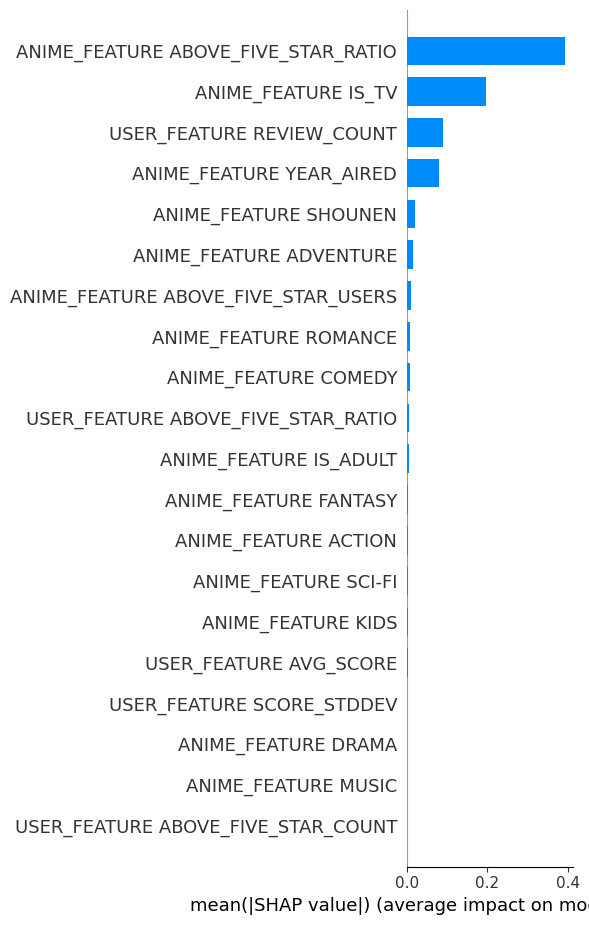

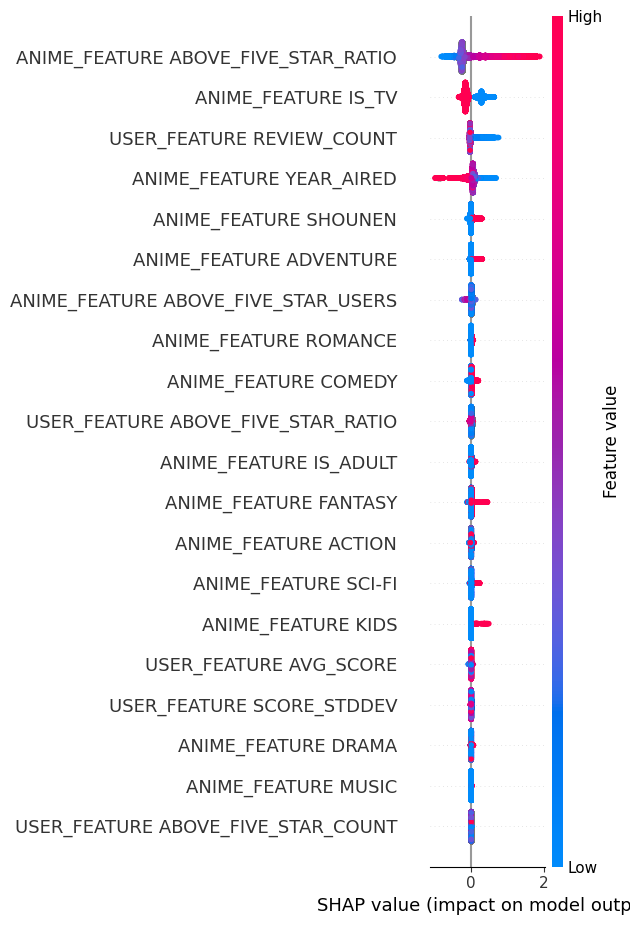

In [56]:
generate_shap_plots(model,xtrain,features,N=10000)

### Referencias

- https://everdark.github.io/k9/notebooks/ml/learning_to_rank/learning_to_rank.html
- https://github.com/Ransaka/LTR-with-LIghtGBM